In [4]:
import numpy as np
import pandas as pd
import scipy.constants as cst
import scipy.special as spc
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='grade3',ticks=True, grid=True, figsize=(12, 7),context='poster',fscale=1.5, spines=True, gridlines='--')
%matplotlib inline

In [5]:
lamda = 1064*10**(-9) #wavelength in nm
k_lamda=2*np.pi/lamda
m_Rb=1.44316*10**(-25) #in kg
Er=(cst.hbar*k_lamda)**2/(2*m_Rb)/cst.h/10**3 #in kHz
#print(Er)
V0=8.0

In [17]:
def geteigen(Vr,Vb,q,bandnum=201):
    s=(2*np.linspace(-(bandnum-1)/2,(bandnum-1)/2,bandnum)+q)**2#+0.5*(Vb-Vr)
    hamiltonian=np.diag([-0.25*Vr]*(bandnum-1),-1)+np.diag([-0.25*Vr]*(bandnum-1),1)+np.diag([0.25*Vb]*(bandnum-2),-2)+np.diag([0.25*Vb]*(bandnum-2),2)+np.diag(s)
    val,vec=np.linalg.eigh(hamiltonian)
    seq=np.argsort(val)
    return val[seq],vec.transpose()[seq]

def blochfunction(V0,q,n,x,xi,bandnum=201):
    basevec=geteigen(V0,q,bandnum)[1][n]#/np.sum(geteigen(V0,q,bandnum)[1],axis=0).reshape(bandnum)
    #print(basevec)
    sumlist=np.linspace(-(bandnum-1)/2,(bandnum-1)/2,bandnum)
    #print(np.exp(2j*k_lamda*sumlist*x)*basevec)
    sumfourier=np.exp(1*1j*q*k_lamda*lamda*x)*np.sum(basevec*np.exp(2j*k_lamda*lamda*sumlist*x))
    #print(1j*q*k_lamda*lamda*x)
    #print(basevec*np.exp(2j*k_lamda*lamda*sumlist*x))
    if n%2==0:
        angle=np.exp(-1j*np.angle(np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*np.exp(2j*k_lamda*sumlist*xi*lamda))))
    else:
        angle=np.exp(-1j*np.angle(np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*(2j*k_lamda*sumlist*lamda+1*1j*q*k_lamda*lamda)*np.exp(2j*k_lamda*sumlist*xi*lamda))))
    #print(np.exp(1*1j*q*k_lamda*0.25*lamda)*np.sum(basevec*np.exp(1j*k_lamda*sumlist*0.25*lamda)))
    sumfourier=sumfourier*angle
    return sumfourier   

def blochfunctionderiv2(V0,q,n,x,xi,bandnum=201):
    basevec=geteigen(V0,q,bandnum)[1][n]#/np.sum(geteigen(V0,q,bandnum)[1],axis=0).reshape(bandnum)
    #print(basevec)
    sumlist=np.linspace(-(bandnum-1)/2,(bandnum-1)/2,bandnum)
    #print(np.exp(2j*k_lamda*sumlist*x)*basevec)
    sumfourier=np.exp(1*1j*q*k_lamda*lamda*x)*np.sum(basevec*(2j*k_lamda*sumlist*lamda+1*1j*q*k_lamda*lamda)**2*np.exp(2j*k_lamda*lamda*sumlist*x))
    #print(1j*q*k_lamda*lamda*x)
    #print(basevec*np.exp(2j*k_lamda*lamda*sumlist*x))
    if n%2==0:
        angle=np.exp(-1j*np.angle(np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*np.exp(2j*k_lamda*sumlist*xi*lamda))))
    else:
        angle=np.exp(-1j*np.angle(np.exp(1*1j*q*k_lamda*xi*lamda)*np.sum(basevec*(2j*k_lamda*sumlist*lamda+1*1j*q*k_lamda*lamda)*np.exp(2j*k_lamda*sumlist*xi*lamda))))
    #print(np.exp(1*1j*q*k_lamda*0.25*lamda)*np.sum(basevec*np.exp(1j*k_lamda*sumlist*0.25*lamda)))
    sumfourier=sumfourier*angle
    return sumfourier   

def WannierState(V0,n,x,xi,bandnum=201):
    qlist=np.linspace(-1,1,401)
    ws=0
    for q in qlist:
        ws=ws+blochfunction(V0,q,n,x,xi,bandnum=bandnum)
    return ws*np.exp(-1j*q*xi*k_lamda*lamda)/(200*np.sqrt(2))

def WannierStatederiv2(V0,n,x,xi,bandnum=201):
    qlist=np.linspace(-1,1,401)
    ws=0
    for q in qlist:
        ws=ws+blochfunctionderiv2(V0,q,n,x,xi,bandnum=bandnum)
    return ws*np.exp(-1j*q*xi*k_lamda*lamda)/(200*np.sqrt(2))

def tunnellingappro(V0,n,bandnum=201):
    ttight=(geteigen(V0,1,bandnum=bandnum)[0][n]-geteigen(V0,0,bandnum=bandnum)[0][n])/4
    return ttight

def tunnellingol(V0,n,bandnum=201):
    xl=np.linspace(-2,2,200)
    toverlap=integrate.simps([np.conj(-WannierState(V0,n,x,0,bandnum=bandnum))*WannierStatederiv2(V0,n,x,0.5,bandnum=bandnum) for x in xl],xl)/(16*np.pi**2)
    return toverlap

In [6]:
%%time
#xl=np.linspace(-1,1,100)
#s=integrate.simps([np.conj(-WannierState(8,0,x,0,bandnum=11))*WannierStatederiv2(8,0,x,0.5,bandnum=11) for x in xl],xl)
v=np.linspace(1,30,29)
t=[tunnellingappro(V0,0,bandnum=11)*Er*1000 for V0 in v]
s=[tunnellingol(V0,0,bandnum=11)*Er*1000 for V0 in v]
print(s,t)

[(109.9511357475076+1.1241251856771306e-14j), (109.71266482950362+6.9475672384850675e-15j), (101.93476540719811+9.984356528840409e-16j), (90.44436180689036+5.49678279599771e-15j), (78.08684891366926+2.2492515469644956e-14j), (66.4285975940558-6.2873767544071424e-15j), (56.13257813679162-1.705433746168464e-14j), (47.35978271413478-1.648728454502238e-14j), (40.03322850745178+6.941412956985264e-14j), (33.982916259568164+2.5460339665065766e-14j), (29.01726506653996-1.320131536154323e-14j), (24.954850214717794-3.612171832644023e-15j), (21.636283564462985+2.265338837029442e-14j), (18.926773026509018+3.561081141870385e-14j), (16.71466105046279+2.4015065779363885e-14j), (14.90850081473353+1.503143522936994e-14j), (13.433847953155372+4.9734918285050986e-14j), (12.230268389482093-4.971019357768633e-14j), (11.248739887114224+4.2525385015509467e-14j), (10.449477370086122-5.73557397448606e-14j), (9.800149950677811+3.024823210264769e-14j), (9.274436101029146-6.6214129671981506e-15j), (8.850860414654

/Users/boxiao/anaconda/envs/Python3/lib/python3.5/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


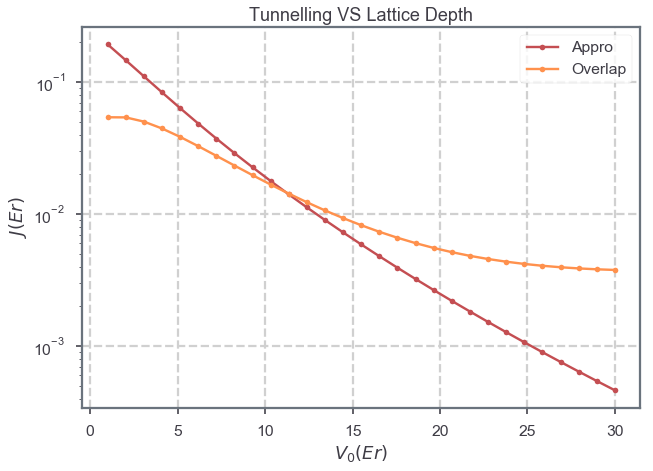

In [7]:
v=np.linspace(1,30,29)
plt.figure(figsize=(10,7))
plt.yscale('log')
plt.title('Tunnelling VS Lattice Depth')
plt.xlabel('$V_{0}(Er)$')
plt.ylabel('$J(Er)$')
plt.plot(v,np.real(t)/1000/Er,'r.-',v,np.array(s)/1000/Er,'y.-')
plt.legend(['Appro','Overlap'],loc='best')

In [11]:
xl=np.linspace(-2,2,200)
s=integrate.simps([np.abs(WannierState(8,0,x,0,bandnum=31))**2 for x in xl],xl)
print(s)

1.00504998921


In [18]:
Vr=16
Vb=16
bandgap20=geteigen(Vr,Vb,0)[0][2]-geteigen(Vr,Vb,0)[0][0]
print('The gap between third band and second band is %0.2f kHz when trap depth is %2.1f Er'%(bandgap20*Er,V0))
qlist=np.linspace(-1,1,50)
eivallist=[]
for q in qlist:
    eivallist.append(geteigen(Vr,Vb,q)[0])
eivallist=np.array(eivallist)

# v=np.linspace(30,60,30)
# plt.figure(figsize=(10,5))
# plt.title('Band Gap vs Trap depth',fontsize=12)
# plt.grid(True)
# plt.xlabel('Lattice Depth(Er)',fontsize=12)
# plt.ylabel('Band Gap(kHz)',fontsize=12)
# plt.xticks(fontsize=12)
# plt.yticks(np.linspace(35,55,5),fontsize=12)
# plt.plot(v,[(geteigen(Vr,Vb,0)[0][2]-geteigen(Vr,Vb,0)[0][0])*Er for v0 in v],'.-',mfc='y',mec='b',markersize=15,label='diag')
# #plt.plot(v,(spc.mathieu_a(2,-v/4)-spc.mathieu_a(0,-v/4))*Er,'*-',label='Mathieu')
# plt.legend(loc='best')

# plt.figure(figsize=(10,5))
# plt.xlabel('Lattice Depth(Er)',fontsize=12)
# plt.ylabel('Error(kHz)',fontsize=12)
# plt.title('Band Gap Error vs Trap depth',fontsize=12)
# plt.xticks(fontsize=12)
# #plt.yticks(np.linspace(35,55,5),fontsize=12)
# plt.plot(v,(spc.mathieu_a(2,-v/4)-spc.mathieu_a(0,-v/4))*Er-[(geteigen(v0,0)[0][2]-geteigen(v0,0)[0][0])*Er for v0 in v],'.-',label='Mathieu')


The gap between third band and second band is 21.56 kHz when trap depth is 8.0 Er


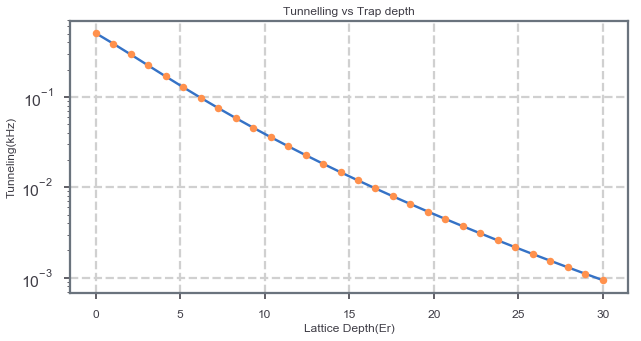

In [6]:
v=np.linspace(0,30,30)
plt.figure(figsize=(10,5))
plt.title('Tunnelling vs Trap depth',fontsize=12)
plt.grid(True)
plt.xlabel('Lattice Depth(Er)',fontsize=12)
plt.ylabel('Tunneling(kHz)',fontsize=12)
plt.xticks(fontsize=12)
plt.yscale('log')
#plt.yticks(np.linspace(35,55,5),fontsize=12)
plt.plot(v,[tunnellingappro(V0,0,bandnum=201)*Er for V0 in v],'.-',mfc='y',mec='b',markersize=15,label='diag')

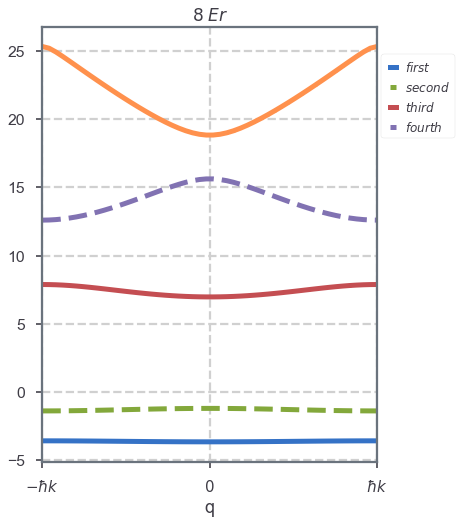

In [19]:
plt.figure(figsize=(6,8),linewidth=22)#,facecolor='w')
plt.grid(True)
#plt.subplots_adjust(right=0.7) 
plt.xlim(-1,1)
plt.xticks(np.linspace(-1,1,3), ('$-\hbar k$','$0$','$\hbar k$'),fontsize='15')
plt.title('$%0.0f$ $Er$'%(V0),fontsize='17')
plt.xlabel('q')
#plt.yticks(np.linspace(-12,12,11),fontsize='15')
plt.plot(qlist,eivallist[:,0],'.-',
         qlist,eivallist[:,1],'--',
         qlist,eivallist[:,2],'.-',
         qlist,eivallist[:,3],'--',
         qlist,eivallist[:,4],'.-',linewidth=5,markersize=5)
plt.legend(['$first$','$second$','$third$','$fourth$'],loc='best',
           fontsize='12',bbox_to_anchor=(1.25,0.95), numpoints=10,prop={'size':12}, handlelength=1.1, handletextpad=0.5)
plt.savefig('BandStructure.pdf',bbox_inches='tight')
plt.show()

CPU times: user 557 ms, sys: 33.8 ms, total: 591 ms
Wall time: 373 ms


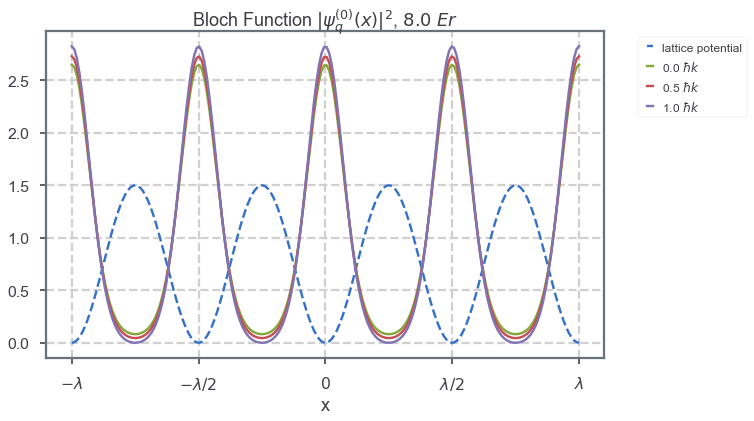

In [9]:
%%time
bandnum=51
xlist=np.linspace(-1,1,200)
#plt.grid(True)

plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.title('Bloch Function $|\psi^{(0)}_{q}(x)|^2$, $%1.1f$ $Er$'%V0)
plt.xticks(np.linspace(-1,1,5),('$-\lambda$','$-\lambda/2$','$0$','$\lambda/2$','$\lambda$'))
qlist=[0,0.5,1]
plt.plot(xlist,1.5*np.cos(k_lamda*lamda*xlist+np.pi/2)**2,'--',label='lattice potential')
for q in qlist:
    plt.plot(xlist,[(np.abs(blochfunction(V0,q,0,x,0,bandnum=bandnum)))**2 for x in xlist],'-',label='%1.1f $\hbar k$'%q)
plt.legend(loc='best',bbox_to_anchor=(1.05,1.00), numpoints=10,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

CPU times: user 912 ms, sys: 19.6 ms, total: 932 ms
Wall time: 490 ms


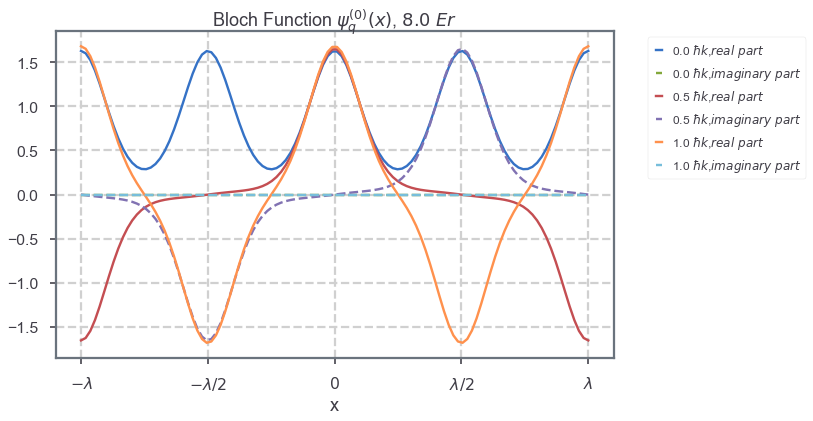

In [9]:
%%time
bandnum=101
xlist=np.linspace(-1,1,110)
plt.figure(figsize=(10,6))
plt.title('Bloch Function $\psi^{(0)}_{q}(x)$, $%1.1f$ $Er$'%V0)
plt.xlabel('x')
plt.grid(True)
qlist=[0,0.5,1]
plt.xticks(np.linspace(-1,1,5),('$-\lambda$','$-\lambda/2$','$0$','$\lambda/2$','$\lambda$'))
for q in qlist:
    plt.plot(xlist,[np.real(blochfunction(V0,q,0,x,0,bandnum=bandnum)) for x in xlist],'-',label='%1.1f $\hbar k$,$real\\ part$'%q)
    plt.plot(xlist,[np.imag(blochfunction(V0,q,0,x,0,bandnum=bandnum)) for x in xlist],'--',label='%1.1f $\hbar k$,$imaginary\\ part$'%q)
plt.legend(loc='best',bbox_to_anchor=(1.05,1.00), numpoints=10,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

CPU times: user 52.1 s, sys: 450 ms, total: 52.5 s
Wall time: 54.1 s


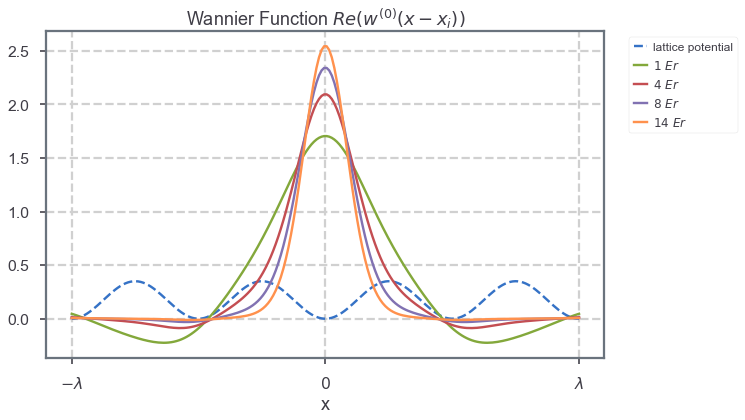

In [10]:
%%time
bandnum=11
xlist=np.linspace(-1,1,200)
#plt.grid(True)
vlist=[1,4,8,14]
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.title('Wannier Function $Re(w^{(0)}(x-x_i))$')
plt.xticks(np.linspace(-2,2,5),('$-2\lambda$','$-\lambda$','$0$','$\lambda$','$2\lambda$'))
plt.plot(xlist,0.35*np.cos(k_lamda*lamda*xlist+np.pi/2)**2,'--',label='lattice potential')
for v in vlist:
    plt.plot(xlist,[np.real(WannierState(v,0,x,0,bandnum=bandnum)) for x in xlist],'-',label='$%1.0f\\ Er$'%v)
plt.legend(loc='best',bbox_to_anchor=(1.25,1.00), numpoints=1,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

CPU times: user 1min 31s, sys: 1.02 s, total: 1min 32s
Wall time: 1min 37s


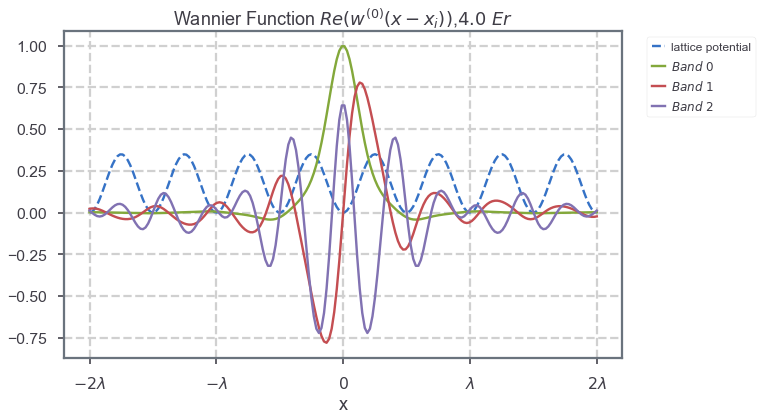

In [11]:
%%time
bandnum=11
xlist=np.linspace(-2,2,200)
V0=4
#plt.grid(True)
nlist=[0,1,2]
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.title('Wannier Function $Re(w^{(0)}(x-x_i))$,$%0.1f\\ Er$'%V0)
plt.xticks(np.linspace(-2,2,5),('$-2\lambda$','$-\lambda$','$0$','$\lambda$','$2\lambda$'))
plt.plot(xlist,0.35*np.cos(k_lamda*lamda*xlist+np.pi/2)**2,'--',label='lattice potential')
for n in nlist:
    plt.plot(xlist,[np.real(WannierState(V0,n,x,0,bandnum=bandnum))/np.real(WannierState(V0,0,0,0,bandnum=bandnum)) for x in xlist],'-',label='$Band\\ %d$'%n)
plt.legend(loc='best',bbox_to_anchor=(1.25,1.00), numpoints=1,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

CPU times: user 1min 48s, sys: 743 ms, total: 1min 49s
Wall time: 1min 50s


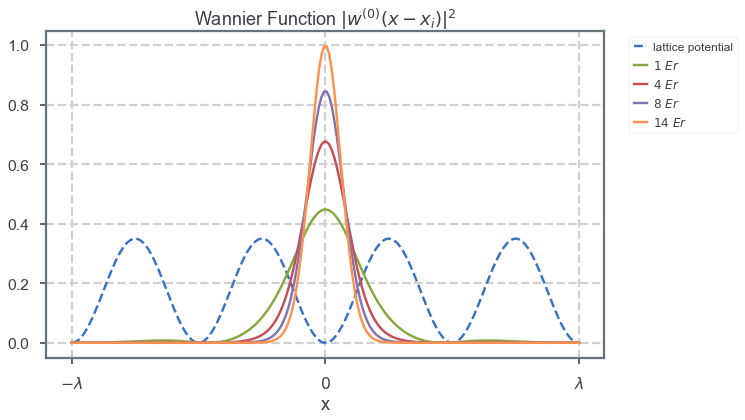

In [12]:
%%time
bandnum=11
xlist=np.linspace(-1,1,200)
#plt.grid(True)
vlist=[1,4,8,14]
plt.figure(figsize=(10,6))
plt.xlabel('x')
plt.title('Wannier Function $|w^{(0)}(x-x_i)|^2$')
plt.xticks(np.linspace(-2,2,5),('$-2\lambda$','$-\lambda$','$0$','$\lambda$','$2\lambda$'))
plt.plot(xlist,0.35*np.cos(k_lamda*lamda*xlist+np.pi/2)**2,'--',label='lattice potential')
for v in vlist:
    plt.plot(xlist,[(np.abs(WannierState(v,0,x,0,bandnum=bandnum)))**2/(np.abs(WannierState(14,0,0,0,bandnum=bandnum)))**2 for x in xlist],'-',label='$%1.0f\\ Er$'%v)
plt.legend(loc='best',bbox_to_anchor=(1.25,1.00), numpoints=1,prop={'size':12}, handlelength=1.1, handletextpad=0.5)

In [ ]:
jdkjsahhdhasjkdhjsahdhaskdhsajhdkjsahdjhsajkdhjsahdjhsajkdhjksahdjksahkjdhsajdhkjsahdjhsajdhsjahdjshadjhsajdhasjhdjsahjdhsajkdhkjashdjksahjdhsjahdjsahdkjshjdhsajdhjsahdjsahdasasjdhsahdhajkdhkjahdjhsjahdjashdjas
shfjkshjfhsjhfjash